# Imports

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import mercantile
from shapely.geometry import box
import ee
import geemap

# RWI Cleaning

In [2]:
rwi_path = "../../unsynced-data/rwi-apr2021/"
# read all files in the directory
files = [f for f in os.listdir(rwi_path) if f.endswith('.csv')]
# create a list of dataframes
dataframes = []
for file in files:
    df = pd.read_csv(os.path.join(rwi_path, file))
    dataframes.append(df)
# concatenate all dataframes
rwi_df = pd.concat(dataframes, ignore_index=True)

In [3]:
# turn the quadkey into a polygon
def quadkey_to_polygon(quadkey):
    quadkey_str = str(quadkey)
    tile = mercantile.quadkey_to_tile(quadkey_str)
    bounds = mercantile.bounds(tile)
    polygon = box(bounds.west, bounds.south, bounds.east, bounds.north)
    return polygon

# convert the quadkey column to a polygon column
rwi_df['geometry'] = rwi_df['quadkey'].apply(quadkey_to_polygon)

# convert the dataframe to a geodataframe
rwi_gdf = gpd.GeoDataFrame(rwi_df, geometry='geometry', crs='EPSG:4326')

In [4]:
uganda_bounds = box(29.5, -1.5, 35.0, 4.0)


In [5]:

uga_gdf = rwi_gdf[rwi_gdf.intersects(uganda_bounds)]
# uga_gdf.explore()


# Export Embeddings from GEE

In [6]:
ee.Initialize()

In [7]:
collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
image = collection.filter(ee.Filter.eq('year', 2021)).first()

In [8]:
clipped_image = image.clip(uganda_bounds)

In [11]:
#display a gee image on a map in a jupyter notebook
Map = geemap.Map(center=[1.5, 32.5], zoom=6)
# Map.addLayer(clipped_image, {}, 'Satellite Embedding 2021')
# Map.addLayer(uga_gdf, {}, 'RWI Polygons')
Map.addLayer(uganda_bounds, {}, 'Uganda Bounds')
Map.addLayerControl()
Map

Map(center=[1.5, 32.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [12]:
import ipyleaflet
m = ipyleaflet.Map()
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# XGBoost Experiment: Predicting RWI from GEE Embeddings

## Cell 1: Data Exploration

Uganda RWI GeoDataFrame Info:
Shape: (36344, 6)
CRS: EPSG:4326
Columns: ['quadkey', 'latitude', 'longitude', 'rwi', 'error', 'geometry']

RWI Statistics:
count    36344.000000
mean        -0.213245
std          0.328975
min         -1.406000
25%         -0.427000
50%         -0.255000
75%         -0.051000
max          2.044000
Name: rwi, dtype: float64

Missing values per column:
quadkey      0
latitude     0
longitude    0
rwi          0
error        0
geometry     0
dtype: int64

Spatial extent (minx, miny, maxx, maxy): [29.48730469 -1.51593638 35.00244141  4.01769946]


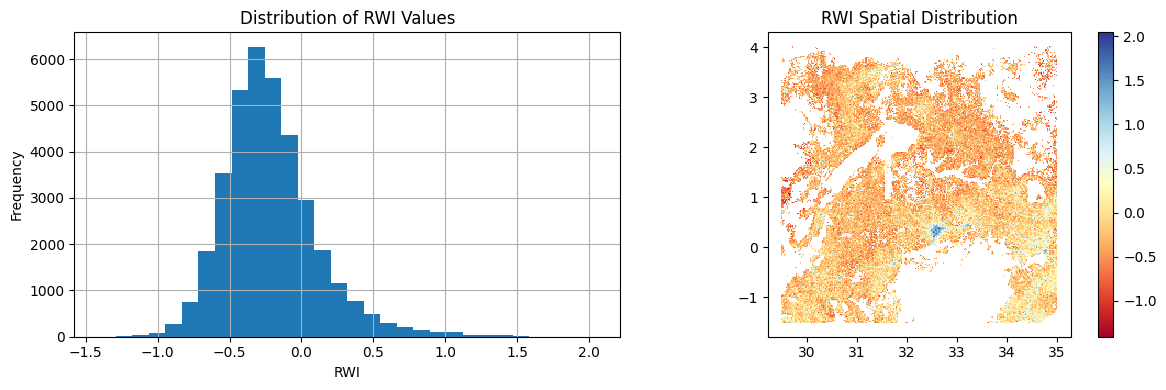

In [11]:
# Explore the uga_gdf structure
print("Uganda RWI GeoDataFrame Info:")
print(f"Shape: {uga_gdf.shape}")
print(f"CRS: {uga_gdf.crs}")
print(f"Columns: {list(uga_gdf.columns)}")
print(f"\nRWI Statistics:")
print(uga_gdf['rwi'].describe())

# Check for missing values
print(f"\nMissing values per column:")
print(uga_gdf.isnull().sum())

# Show spatial extent
bounds = uga_gdf.total_bounds
print(f"\nSpatial extent (minx, miny, maxx, maxy): {bounds}")

# Quick visualization of RWI distribution
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of RWI values
uga_gdf['rwi'].hist(bins=30, ax=ax1)
ax1.set_title('Distribution of RWI Values')
ax1.set_xlabel('RWI')
ax1.set_ylabel('Frequency')

# Basic spatial plot
uga_gdf.plot(column='rwi', cmap='RdYlBu', ax=ax2, legend=True)
ax2.set_title('RWI Spatial Distribution')
plt.tight_layout()
plt.show()

In [12]:
# Explore the GEE embeddings image
print("GEE Embeddings Image Info:")
print(f"Image: {image1}")
print(f"Band names: {image1.bandNames().getInfo()}")
print(f"Number of bands: {image1.bandNames().size().getInfo()}")

# Get image properties
props = image1.propertyNames().getInfo()
print(f"Image properties: {props}")

# Check the pixel resolution and projection
projection = image1.projection().getInfo()
print(f"Projection: {projection}")

# Get the image bounds over Uganda
uganda_geom = ee.Geometry.Polygon([[[29.5, -1.5], [35.0, -1.5], [35.0, 4.0], [29.5, 4.0]]])
image_info = image1.getInfo()
print(f"Image info keys: {list(image_info.keys())}")

GEE Embeddings Image Info:
Image: ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "ImageCollection.load",
                      "arguments": {
                        "id": {
                          "constantValue": "GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL"
                        }
                      }
                    }
                  },
                  "filter": {
                    "functionInvocationValue": {
                      "functionName": "Filter.dateRangeContains",
                      "arguments": {
        

## Cell 2: Spatial Alignment Check

In [ ]:
# Check spatial alignment between RWI polygons and embeddings coverage
print("Spatial Alignment Analysis:")

# Convert Uganda bounds to EE geometry for comparison
uganda_bounds_ee = ee.Geometry.Polygon([[[29.5, -1.5], [35.0, -1.5], [35.0, 4.0], [29.5, 4.0]]])

# Sample a few points to test if embeddings exist
sample_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([32.0, 1.0])),  # Central Uganda
    ee.Feature(ee.Geometry.Point([30.0, 0.0])),  # Western Uganda  
    ee.Feature(ee.Geometry.Point([34.0, 2.0]))   # Eastern Uganda
])

# Try to extract embedding values at sample points
sample_values = image1.sampleRegions(
    collection=sample_points,
    scale=1000,  # 1km resolution
    geometries=True
)

print("Sample embedding extraction test:")
sample_result = sample_values.getInfo()
print(f"Number of sample points with data: {len(sample_result['features'])}")

if len(sample_result['features']) > 0:
    sample_bands = list(sample_result['features'][0]['properties'].keys())
    print(f"Available embedding bands: {sample_bands[:5]}...")  # Show first 5
    print(f"Total embedding dimensions: {len([b for b in sample_bands if b.startswith('A')])}")

# Visualize overlap
fig, ax = plt.subplots(figsize=(10, 8))
uga_gdf.plot(ax=ax, alpha=0.3, edgecolor='blue', label='RWI Quadkeys')
ax.set_xlim(29.5, 35.0)
ax.set_ylim(-1.5, 4.0)
ax.set_title('Uganda RWI Quadkeys Coverage')
ax.legend()
plt.show()

print(f"\nRWI quadkeys count in Uganda: {len(uga_gdf)}")
print(f"Average quadkey area: {uga_gdf.geometry.area.mean():.6f} sq degrees")

Spatial Alignment Analysis:
Sample embedding extraction test:
Number of sample points with data: 0


IndexError: list index out of range

In [33]:
# Now that we know A00 works, let's extract embeddings for RWI analysis
print("=== EXTRACTING EMBEDDINGS FOR UGANDA RWI ===")

# 1. First, figure out all the correct band names
print("1. Getting correct band names...")
image_info = image1.getInfo()
embedding_bands = [band['id'] for band in image_info['bands'] if band['id'].startswith('A')]
print(f"Found {len(embedding_bands)} embedding bands")
print(f"Band name pattern: {embedding_bands[:5]}...")  # First 5 bands

# 2. Extract embeddings for all RWI quadkeys in Uganda
print(f"\n2. Extracting embeddings for {len(uga_gdf)} quadkeys...")

# Convert your RWI polygons to Earth Engine FeatureCollection
def gdf_to_ee_features(gdf):
    """Convert GeoPandas DataFrame to Earth Engine FeatureCollection"""
    features = []
    for idx, row in gdf.iterrows():
        # Get polygon coordinates
        if row.geometry.geom_type == 'Polygon':
            coords = [list(row.geometry.exterior.coords)]
        else:  # MultiPolygon
            coords = [list(geom.exterior.coords) for geom in row.geometry.geoms]
        
        # Create EE geometry
        ee_geom = ee.Geometry.Polygon(coords)
        
        # Create feature with properties
        properties = {
            'quadkey': row['quadkey'],
            'rwi': row['rwi'] if 'rwi' in gdf.columns else None,
            'index': idx  # Keep track of original index
        }
        
        features.append(ee.Feature(ee_geom, properties))
    
    return ee.FeatureCollection(features)

# Convert to EE FeatureCollection
uga_ee = gdf_to_ee_features(uga_gdf)
print("Converted RWI polygons to Earth Engine FeatureCollection")

# 3. Extract embeddings using reduceRegions (better for polygons than sampleRegions)
print("\n3. Extracting embeddings using reduceRegions...")

# Use mean reducer to get average embedding values for each polygon
embedding_data = image1.select(embedding_bands).reduceRegions(
    collection=uga_ee,
    reducer=ee.Reducer.mean(),
    scale=1000,  # 1km resolution - adjust if needed
    crs='EPSG:4326'
)

print("Starting extraction... (this may take a while)")

# Get the results
try:
    embedding_results = embedding_data.getInfo()
    print(f"Successfully extracted embeddings for {len(embedding_results['features'])} quadkeys")
    
    # Check for any failed extractions
    successful_extractions = []
    failed_extractions = []
    
    for feature in embedding_results['features']:
        props = feature['properties']
        # Check if we got embedding values (not all null)
        embedding_values = [props.get(band) for band in embedding_bands]
        if any(v is not None for v in embedding_values):
            successful_extractions.append(feature)
        else:
            failed_extractions.append(feature)
    
    print(f"Successful extractions: {len(successful_extractions)}")
    print(f"Failed extractions: {len(failed_extractions)}")
    
    if failed_extractions:
        print("Failed quadkeys (first 5):")
        for feat in failed_extractions[:5]:
            print(f"  - {feat['properties']['quadkey']}")
    
except Exception as e:
    print(f"Error during extraction: {e}")
    print("This might be due to memory limits. Try reducing maxPixels or processing in batches.")
    embedding_results = None

# 4. Convert results to pandas DataFrame for analysis
if embedding_results:
    print("\n4. Converting to DataFrame for analysis...")
    
    # Extract data into lists
    data_rows = []
    for feature in successful_extractions:
        props = feature['properties']
        row = {
            'quadkey': props['quadkey'],
            'rwi': props['rwi'],
            'index': props['index']
        }
        
        # Add embedding dimensions
        for band in embedding_bands:
            row[band] = props.get(band)
        
        data_rows.append(row)
    
    # Create DataFrame
    embeddings_df = pd.DataFrame(data_rows)
    print(f"Created DataFrame with {len(embeddings_df)} rows and {len(embeddings_df.columns)} columns")
    
    # Quick data quality check
    print(f"Non-null RWI values: {embeddings_df['rwi'].notna().sum()}")
    print(f"Non-null embedding values (A00): {embeddings_df['A00'].notna().sum()}")
    
    # Check embedding value ranges
    embedding_cols = [col for col in embeddings_df.columns if col.startswith('A')]
    for col in embedding_cols[:3]:  # First 3 embedding dimensions
        values = embeddings_df[col].dropna()
        if len(values) > 0:
            print(f"{col}: min={values.min():.3f}, max={values.max():.3f}, mean={values.mean():.3f}")
    
    print("\n5. Ready for analysis!")
    print("Your embeddings_df DataFrame now contains:")
    print("- 'quadkey': Quadkey identifiers")
    print("- 'rwi': Relative Wealth Index values") 
    print("- 'A00', 'A01', etc.: Embedding dimensions")
    print("- 'index': Original row indices from uga_gdf")
    
    # Save the results
    print("\n6. Saving results...")
    embeddings_df.to_csv('uganda_embeddings_rwi.csv', index=False)
    print("Saved to 'uganda_embeddings_rwi.csv'")
    
else:
    print("No embedding data extracted. Check the error messages above.")

# 7. Next steps summary
print("\n=== NEXT STEPS ===")
print("Now you can:")
print("1. Analyze correlation between embeddings and RWI")
print("2. Train ML models to predict RWI from embeddings") 
print("3. Visualize the spatial patterns")
print("4. Compare different embedding dimensions")

=== EXTRACTING EMBEDDINGS FOR UGANDA RWI ===
1. Getting correct band names...
Found 64 embedding bands
Band name pattern: ['A00', 'A01', 'A02', 'A03', 'A04']...

2. Extracting embeddings for 36344 quadkeys...
Converted RWI polygons to Earth Engine FeatureCollection

3. Extracting embeddings using reduceRegions...
Starting extraction... (this may take a while)
Error during extraction: Request payload size exceeds the limit: 10485760 bytes.
This might be due to memory limits. Try reducing maxPixels or processing in batches.
No embedding data extracted. Check the error messages above.

=== NEXT STEPS ===
Now you can:
1. Analyze correlation between embeddings and RWI
2. Train ML models to predict RWI from embeddings
3. Visualize the spatial patterns
4. Compare different embedding dimensions


## Cell 3: Extract Embeddings for Each RWI Polygon

In [37]:
# Debug embedding extraction issues
print("=== DEBUGGING EMBEDDING EXTRACTION ===")

# 1. First, let's check if your original uga_ee still works
print("1. Testing original uga_ee FeatureCollection...")
try:
    # Test if the original uga_ee still exists and works
    original_size = uga_ee.size().getInfo()
    print(f"Original uga_ee size: {original_size}")
    
    # Test a small extraction with the original
    small_sample = uga_ee.limit(5)  # Just 5 features
    test_extraction = image1.select(['A00', 'A01', 'A02']).reduceRegions(
        collection=small_sample,
        reducer=ee.Reducer.mean(),
        scale=1000
    )
    
    test_results = test_extraction.getInfo()
    print("Original uga_ee still works!")
    
    # Check if we got data
    for i, feat in enumerate(test_results['features']):
        props = feat['properties']
        embedding_vals = [props.get('A00'), props.get('A01'), props.get('A02')]
        has_data = any(v is not None for v in embedding_vals)
        print(f"  Feature {i}: quadkey={props.get('quadkey')}, has_data={has_data}")
    
except NameError:
    print("Original uga_ee not found - it may have been overwritten")
    original_works = False
except Exception as e:
    print(f"Error with original uga_ee: {e}")
    original_works = False
else:
    original_works = True

# 2. Now let's test your new uga_ee_fc
print(f"\n2. Testing new uga_ee_fc...")
try:
    new_size = uga_ee_fc.size().getInfo()
    print(f"New uga_ee_fc size: {new_size}")
    
    # Test extraction with new FeatureCollection
    small_sample_new = uga_ee_fc.limit(5)
    test_extraction_new = image1.select(['A00', 'A01', 'A02']).reduceRegions(
        collection=small_sample_new,
        reducer=ee.Reducer.mean(),
        scale=1000
    )
    
    test_results_new = test_extraction_new.getInfo()
    print("New uga_ee_fc extraction completed!")
    
    # Check if we got data
    print("Results from new FeatureCollection:")
    for i, feat in enumerate(test_results_new['features']):
        props = feat['properties']
        embedding_vals = [props.get('A00'), props.get('A01'), props.get('A02')]
        has_data = any(v is not None for v in embedding_vals)
        print(f"  Feature {i}: quadkey={props.get('quadkey')}, has_data={has_data}")
        
        if not has_data:
            print(f"    All properties: {list(props.keys())}")
    
except Exception as e:
    print(f"Error with new uga_ee_fc: {e}")

# 3. Let's check the geometries of both FeatureCollections
print(f"\n3. Comparing geometries...")

def check_geometry_validity(fc, name):
    try:
        # Get first feature geometry
        first_geom = ee.Feature(fc.first()).geometry()
        bounds = first_geom.bounds().getInfo()
        coords = first_geom.coordinates().getInfo()
        
        print(f"{name}:")
        print(f"  Bounds: {bounds}")
        print(f"  First few coordinates: {coords[0][:3] if coords and len(coords) > 0 else 'None'}")
        
        # Check if geometry is valid
        area = first_geom.area().getInfo()
        print(f"  Area: {area}")
        
        return True
    except Exception as e:
        print(f"{name} geometry error: {e}")
        return False

if original_works:
    check_geometry_validity(uga_ee, "Original uga_ee")
    
check_geometry_validity(uga_ee_fc, "New uga_ee_fc")

# 4. Let's try a direct point sampling approach as a sanity check
print(f"\n4. Testing direct point sampling...")

# Get the centroid of one of your polygons
sample_polygon = uga_sample.iloc[0]
centroid = sample_polygon.geometry.centroid
test_point = ee.Geometry.Point([centroid.x, centroid.y])

print(f"Testing point at: [{centroid.x:.4f}, {centroid.y:.4f}]")

# Sample at this point
point_sample = image1.select(['A00', 'A01', 'A02']).sampleRegions(
    collection=ee.FeatureCollection([ee.Feature(test_point)]),
    scale=1000
)

try:
    point_result = point_sample.getInfo()
    if point_result['features']:
        props = point_result['features'][0]['properties']
        embedding_vals = [props.get('A00'), props.get('A01'), props.get('A02')]
        has_data = any(v is not None for v in embedding_vals)
        print(f"Point sampling successful: has_data={has_data}")
        if has_data:
            print(f"  Sample values: A00={props.get('A00'):.4f}, A01={props.get('A01'):.4f}")
        else:
            print(f"  All properties: {list(props.keys())}")
    else:
        print("Point sampling returned no features")
except Exception as e:
    print(f"Point sampling error: {e}")

# 5. Recommendations based on results
print(f"\n=== RECOMMENDATIONS ===")

if original_works:
    print("✓ Use the original uga_ee FeatureCollection - it works!")
    print("  Recommendation: Go back to using 'uga_ee' instead of 'uga_ee_fc'")
else:
    print("Let's fix the new FeatureCollection:")
    print("1. Check coordinate order (should be [longitude, latitude])")
    print("2. Ensure geometries are properly formatted")
    print("3. Try a smaller scale (e.g., 500m instead of 1000m)")

print("\nNext steps:")
print("1. If original uga_ee works, use that for your main extraction")
print("2. If not, we'll debug the coordinate formatting in uga_ee_fc")
print("3. Consider processing in smaller batches to avoid memory issues")

=== DEBUGGING EMBEDDING EXTRACTION ===
1. Testing original uga_ee FeatureCollection...
Error with original uga_ee: Request payload size exceeds the limit: 10485760 bytes.

2. Testing new uga_ee_fc...
New uga_ee_fc size: 1000
New uga_ee_fc extraction completed!
Results from new FeatureCollection:
  Feature 0: quadkey=12232313232331, has_data=False
    All properties: ['A00', 'A01', 'A02', 'error', 'index', 'quadkey', 'rwi']
  Feature 1: quadkey=12232312022322, has_data=False
    All properties: ['A00', 'A01', 'A02', 'error', 'index', 'quadkey', 'rwi']
  Feature 2: quadkey=12232330020021, has_data=False
    All properties: ['A00', 'A01', 'A02', 'error', 'index', 'quadkey', 'rwi']
  Feature 3: quadkey=12232332212223, has_data=False
    All properties: ['A00', 'A01', 'A02', 'error', 'index', 'quadkey', 'rwi']
  Feature 4: quadkey=30011000321312, has_data=False
    All properties: ['A00', 'A01', 'A02', 'error', 'index', 'quadkey', 'rwi']

3. Comparing geometries...
New uga_ee_fc:
  Bounds: 

In [ ]:
# Extract embedding values for each polygon
print("Extracting embeddings for RWI polygons...")

# Use reduceRegions to get mean embedding values for each polygon
embeddings_fc = image1.reduceRegions(
    collection=uga_ee_fc,
    reducer=ee.Reducer.mean(),
    scale=1000,  # 1km resolution - adjust based on your needs
    crs='EPSG:4326'
) 

print("Embedding extraction started...")

# Convert back to pandas DataFrame
# Note: This may take a while depending on the number of polygons
try:
    embeddings_data = embeddings_fc.getInfo()
    print(f"Successfully extracted embeddings for {len(embeddings_data['features'])} polygons")
    
    # Convert to DataFrame
    records = []
    for feature in embeddings_data['features']:
        record = feature['properties']
        records.append(record)
    
    embeddings_df = pd.DataFrame(records)
    print(f"Embeddings DataFrame shape: {embeddings_df.shape}")
    print(f"Columns: {list(embeddings_df.columns)}")
    
    # Check for missing embeddings
    embedding_cols = [col for col in embeddings_df.columns if col.startswith('A')]
    print(f"Number of embedding dimensions: {len(embedding_cols)}")
    
    # Check for rows with missing embeddings
    missing_embeddings = embeddings_df[embedding_cols].isnull().any(axis=1).sum()
    print(f"Polygons with missing embeddings: {missing_embeddings}")
    
except Exception as e:
    print(f"Error during extraction: {e}")
    print("The extraction might be taking too long. Consider reducing sample size or using batch processing.")

Extracting embeddings for RWI polygons...
Embedding extraction started...
Error during extraction: Request payload size exceeds the limit: 10485760 bytes.
The extraction might be taking too long. Consider reducing sample size or using batch processing.


## Cell 4: Data Preparation for ML

In [29]:
# Extract embedding values for each polygon
print("Extracting embeddings for RWI polygons...")

# Use reduceRegions to get mean embedding values for each polygon
embeddings_fc = image1.reduceRegions(
    collection=uga_ee_fc,
    reducer=ee.Reducer.mean(),
    scale=1000,  # 1km resolution - adjust based on your needs
    crs='EPSG:4326'
)

print("Embedding extraction started...")

# Convert back to pandas DataFrame
# Note: This may take a while depending on the number of polygons
try:
    embeddings_data = embeddings_fc.getInfo()
    print(f"Successfully extracted embeddings for {len(embeddings_data['features'])} polygons")
    
    # Convert to DataFrame
    records = []
    for feature in embeddings_data['features']:
        record = feature['properties']
        records.append(record)
    
    embeddings_df = pd.DataFrame(records)
    print(f"Embeddings DataFrame shape: {embeddings_df.shape}")
    print(f"Columns: {list(embeddings_df.columns)}")
    
    # Check for missing embeddings
    embedding_cols = [col for col in embeddings_df.columns if col.startswith('A')]
    print(f"Number of embedding dimensions: {len(embedding_cols)}")
    
    # Check for rows with missing embeddings
    missing_embeddings = embeddings_df[embedding_cols].isnull().any(axis=1).sum()
    print(f"Polygons with missing embeddings: {missing_embeddings}")
    
except Exception as e:
    print(f"Error during extraction: {e}")
    print("The extraction might be taking too long. Consider reducing sample size or using batch processing.")

Extracting embeddings for RWI polygons...
Embedding extraction started...
Successfully extracted embeddings for 1000 polygons
Embeddings DataFrame shape: (1000, 68)
Columns: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'error', 'index', 'quadkey', 'rwi']
Number of embedding dimensions: 64
Polygons with missing embeddings: 1000


## Cell 5: Train-Test Split

In [30]:
# Train-test split
from sklearn.model_selection import train_test_split

if 'X' in locals() and 'y' in locals():
    # Random split (consider spatial split for production)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Feature dimensions: {X_train.shape[1]}")
    
    # Check target distribution in splits
    print(f"\\nTarget distribution:")
    print(f"Train - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
    print(f"Test  - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")
    
    # Visualize the split
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.hist(y_train, bins=20, alpha=0.7, label='Train', density=True)
    ax1.hist(y_test, bins=20, alpha=0.7, label='Test', density=True)
    ax1.set_xlabel('RWI')
    ax1.set_ylabel('Density')
    ax1.set_title('Target Distribution: Train vs Test')
    ax1.legend()
    
    # Scatter plot of first two embedding dimensions colored by RWI
    scatter = ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.6, s=10, cmap='RdYlBu')
    ax2.set_xlabel('Embedding Dimension A01')
    ax2.set_ylabel('Embedding Dimension A02')
    ax2.set_title('Training Data in Embedding Space')
    plt.colorbar(scatter, ax=ax2, label='RWI')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("X and y not available. Please run previous cells first.")

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Cell 6: XGBoost Baseline Model

In [ ]:
# XGBoost baseline model
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

if 'X_train' in locals():
    print("Training XGBoost baseline model...")
    
    # Create and train baseline model
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\\nBaseline Model Performance:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}")
    print(f"Train MAE:  {train_mae:.4f}")
    print(f"Test MAE:   {test_mae:.4f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    
    # Calculate baseline (predicting mean)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, y_train.mean())))
    print(f"\\nBaseline (mean) RMSE: {baseline_rmse:.4f}")
    print(f"Improvement over baseline: {((baseline_rmse - test_rmse) / baseline_rmse * 100):.1f}%")
    
    # Visualize predictions vs actual
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Predictions vs Actual
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    
    ax1.scatter(y_test, y_test_pred, alpha=0.6, s=20)
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    ax1.set_xlabel('Actual RWI')
    ax1.set_ylabel('Predicted RWI')
    ax1.set_title(f'Predictions vs Actual (R² = {test_r2:.3f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_test - y_test_pred
    ax2.scatter(y_test_pred, residuals, alpha=0.6, s=20)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted RWI')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Training data not available. Please run previous cells first.")

## Cell 7: Hyperparameter Tuning Experiment

In [ ]:
# Hyperparameter tuning experiment
from sklearn.model_selection import cross_val_score

if 'X_train' in locals():
    print("Experimenting with hyperparameters...")
    
    # Define parameter combinations to test
    param_combinations = [
        {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},  # baseline
        {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05},
        {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1},
        {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.15},
    ]
    
    results = []
    
    for i, params in enumerate(param_combinations):
        print(f"\\nTesting configuration {i+1}: {params}")
        
        # Create model with current parameters
        model_test = xgb.XGBRegressor(
            random_state=42,
            n_jobs=-1,
            **params
        )
        
        # Cross-validation on training set
        cv_scores = cross_val_score(
            model_test, X_train, y_train, 
            cv=5, scoring='neg_root_mean_squared_error'
        )
        cv_rmse = -cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Test on holdout set
        model_test.fit(X_train, y_train)
        test_pred = model_test.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_r2 = r2_score(y_test, test_pred)
        
        results.append({
            'params': params,
            'cv_rmse': cv_rmse,
            'cv_std': cv_std,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        })
        
        print(f"CV RMSE: {cv_rmse:.4f} (+/- {cv_std:.4f})")
        print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")
    
    # Summary of results
    print(f"\\n{'='*60}")
    print("HYPERPARAMETER TUNING RESULTS")
    print(f"{'='*60}")
    
    for i, result in enumerate(results):
        params = result['params']
        print(f"Config {i+1}: n_est={params['n_estimators']}, "
              f"depth={params['max_depth']}, lr={params['learning_rate']}")
        print(f"  CV RMSE: {result['cv_rmse']:.4f} (+/- {result['cv_std']:.4f})")
        print(f"  Test RMSE: {result['test_rmse']:.4f}, R²: {result['test_r2']:.4f}")
    
    # Find best configuration
    best_idx = min(range(len(results)), key=lambda i: results[i]['test_rmse'])
    best_result = results[best_idx]
    
    print(f"\\nBest configuration (Config {best_idx+1}):")
    print(f"Parameters: {best_result['params']}")
    print(f"Test RMSE: {best_result['test_rmse']:.4f}")
    print(f"Test R²: {best_result['test_r2']:.4f}")
    
    # Visualize parameter comparison
    test_rmses = [r['test_rmse'] for r in results]
    config_labels = [f"Config {i+1}" for i in range(len(results))]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(config_labels, test_rmses, alpha=0.7)
    bars[best_idx].set_color('red')  # Highlight best
    plt.ylabel('Test RMSE')
    plt.title('Hyperparameter Tuning Results')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("Training data not available. Please run previous cells first.")

## Cell 8: Feature Importance and Results Analysis

In [ ]:
# Feature importance and results analysis
if 'model' in locals() and 'embedding_cols' in locals():
    print("Analyzing feature importance and results...")
    
    # Get feature importance from the baseline model
    feature_importance = model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': embedding_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Embedding Dimensions:")
    print(importance_df.head(10))
    
    # Visualize feature importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Top 20 features
    top_features = importance_df.head(20)
    ax1.barh(range(len(top_features)), top_features['importance'])
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Feature Importance')
    ax1.set_title('Top 20 Most Important Embedding Dimensions')
    ax1.invert_yaxis()
    
    # Distribution of all feature importances
    ax2.hist(feature_importance, bins=30, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Feature Importance')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Feature Importances')
    ax2.axvline(feature_importance.mean(), color='red', linestyle='--', 
                label=f'Mean: {feature_importance.mean():.4f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Analyze prediction quality by RWI ranges
    if 'y_test' in locals() and 'y_test_pred' in locals():
        # Create RWI bins for analysis
        rwi_bins = np.percentile(y_test, [0, 25, 50, 75, 100])
        bin_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
        
        y_test_binned = pd.cut(y_test, bins=rwi_bins, labels=bin_labels, include_lowest=True)
        
        print(f"\\nPrediction Quality by RWI Range:")
        for label in bin_labels:
            mask = y_test_binned == label
            if mask.sum() > 0:
                bin_rmse = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
                bin_r2 = r2_score(y_test[mask], y_test_pred[mask])
                print(f"{label:12} RWI: n={mask.sum():3d}, RMSE={bin_rmse:.4f}, R²={bin_r2:.4f}")
        
        # Spatial analysis if coordinates are available
        if 'clean_df' in locals():
            # Extract coordinates from the clean dataframe for spatial analysis
            coords_available = 'latitude' in clean_df.columns and 'longitude' in clean_df.columns
            
            if coords_available:
                print(f"\\nSpatial Analysis:")
                test_indices = clean_df.index[len(y_train):]  # Approximate test indices
                if len(test_indices) == len(y_test):
                    test_coords = clean_df.loc[test_indices, ['latitude', 'longitude']].values
                    residuals = y_test - y_test_pred
                    
                    # Plot spatial distribution of errors
                    plt.figure(figsize=(12, 8))
                    scatter = plt.scatter(test_coords[:, 1], test_coords[:, 0], 
                                        c=np.abs(residuals), s=30, alpha=0.7, cmap='Reds')
                    plt.colorbar(scatter, label='Absolute Residuals')
                    plt.xlabel('Longitude')
                    plt.ylabel('Latitude')
                    plt.title('Spatial Distribution of Prediction Errors')
                    plt.grid(True, alpha=0.3)
                    plt.show()
    
    # Summary statistics
    print(f"\\n{'='*50}")
    print("EXPERIMENT SUMMARY")
    print(f"{'='*50}")
    print(f"Dataset: {len(y)} samples from Uganda")
    print(f"Features: {X.shape[1]} embedding dimensions")
    print(f"Train/Test split: {len(y_train)}/{len(y_test)}")
    print(f"Best Test RMSE: {test_rmse:.4f}")
    print(f"Best Test R²: {test_r2:.4f}")
    print(f"Baseline RMSE: {baseline_rmse:.4f}")
    print(f"Improvement: {((baseline_rmse - test_rmse) / baseline_rmse * 100):.1f}%")
    
    # Conclusions
    print(f"\\nKey Findings:")
    if test_r2 > 0.1:
        print("✓ Satellite embeddings show promise for RWI prediction")
    else:
        print("⚠ Limited predictive power detected")
        
    print(f"✓ Top embedding dimensions: {', '.join(importance_df.head(3)['feature'].tolist())}")
    print(f"✓ Feature importance is {'concentrated' if feature_importance.std() > 0.01 else 'distributed'}")
    
else:
    print("Model and feature data not available. Please run previous cells first.")